# Improved Deep Q-Network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/06-deep-reinforcement-learning/03-improved-deep-q-network.ipynb)

We continue to elaborate the DQN algorithm by presenting two additional techniques for  improving the sample-efficiency.  First, we introduce a functional neural network architecture that splits the Q-function representation into two streams (one for the V-function and the other for the A-function). With this a single experience tuple can help improve the value estimates of all the actions in that state. The second improvement is related to the replay buffer: we introduce a different technique for sampling experiences that allows us to draw samples that appear to provide the most information to the agent for actually making improvements.

1. [RL-aware neural network architecture](#RL-aware-neural-network-architecture)
2. [Dueling DDQN](#Dueling-DDQN)
3. [Dueling DDQN vs DDQN](#Dueling-DDQN-vs-DDQN)
4. [Prioritizing the replay of experiences](#Prioritizing-the-replay-of-experiences)
5. [PER vs Dueling DDQN](#PER-vs-Dueling-DDQN)
6. [Challenges](#Challenges)


## RL-aware neural network architecture

The dueling network is an improvement that applies only to the net work architecture and not the algorithm. Until now, we concentrated our efforts on making reinforcement learning look more like a supervised learning problem: using the replay memory we made data more like an independent and identically distributed dataset; using two networks we made targets look more static. This helps stabilize training, but ignoring the fact that reinforcement learning problems are problems of their own isn’t the smartest approach to solving these problems.

Now we try to exploit the subtleties of value-based deep reinforcement learning agents, in particular the way the value functions relate to one another. More specifically, we can use the fact that the state-value function $V(s)$ and the action-value function $Q(s, a)$ are related to each other through the action-advantage function $A(s, a)$:

Recall the state-value function of state $s$ for a policy $\pi$ is the expectation of returns from that state, assuming you continue following that policy:

$\begin{align}
v_{\pi}(s) = E_{\pi}[G_t | S_t=s]  
\end{align}$

the action-value function of a policy $\pi$ is its expectatio of returns given you take action $a$ in state $s$ and continue following that policy:

$\begin{align}
q_{\pi}(s,a) = E_{\pi}[G_t | S_t=s, A_t=a]  
\end{align}$

we can define the **action-advantage function** as the difference between taking action $a$ in state $s$ and choosing the policy’s default action:

$\begin{align}
a_{\pi}(s,a) = q_{\pi}(s,a) - v_{\pi}(s)
\end{align}$

we can observe that infinitely sampling the policy yields the expeceted value of the action-advantage to zero (because there’s no advantage in taking the default action):

$\begin{align}
E_{a \backsim  \pi(s)} [a_{\pi}(s,a)] = 0
\end{align}$

finally, we can rewrite this and observe that the action-value function $Q(s, a)$ can be defined as the sum of the state-value function $V(s)$ and the action-advantage function $A(s, a)$. This means that we can decompose a Q-function into two components: one that’s shared across all actions, and another that’s unique to each action:

$\begin{align}
q_{\pi}(s,a) = v_{\pi}(s) + a_{\pi}(s,a)
\end{align}$


This means that we’re learning the action-value function $Q(s, a)$ inefficiently, becouse information is shared between the nodes of a network. But, when learning about $Q(s, a_1)$, we’re ignoring the fact that we could use the same information to learn something about $Q(s, a_2)$, $Q(s, a_3)$, and all other actions available in state $s$. The fact is that $V(s)$ is common to all actions $a_1$, $a_2$, $a_3$, ..., $a_N$.

<img src="./images/dueling.png" width="600">

The bottom line is that **the values of actions depend on the values of states**, and it would be
nice to leverage this fact. In the end, taking the worst action in a good state could be better than taking the best action in a bad state.

The **dueling network architecture** ([Ziyu et al. **Dueling
Network Architectures for Deep Reinforcement Learning**, ICML 2016](https://arxiv.org/abs/1511.06581))consists of creating two separate estimators, one of the
state-value function $V(s)$, and the other of the action-advantage function $A(s, a)$. After sharing most of the internal nodes and layers, the layer before the output layers splits into two streams: a stream for the state-value function $V(s)$, and another for the action-advantage function $A(s, a)$. The V-function output layer always ends in a single node because the value of a state is always a single number. The output layer for the Q-function, however, outputs a vector of the same size as the number of actions:

<img src="./images/dueling-network.png" width="600">


Now, we need to find a way to aggregate the two outputs from the network and reconstruct the action-value function $Q(s, a)$. How do we join the outputs? Some of you are thinking, add them up, right?  The Q-function is parameterized by theta (weights of the shared layers), alpha (weights of the action-advantage function stream), and beta (weights of the state-value function stream):

$\begin{align}
Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + A(s,a;\theta,\alpha)
\end{align}$

However, notice that we cannot uniquely recover the Q from V and A (think about it: if we add +10 to V and remove it from A we obtain the same Q with two different values for V and A), we use the above equation in practice. The way to address this issue is by subtracting the mean of the advantages from the aggregated action-value function estimate. Doing this stabilizes the optimization process:

$\begin{align}
Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + \left( A(s,a;\theta,\alpha) - \frac{1}{|A|}\sum\limits_{a'}{A(s,a;\theta,\alpha)} \right) 
\end{align}$

We can build in Python:

In [52]:
import torch.nn as nn
import torch.nn.functional as F

class FCDuelingQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        # it is similar to the regular network. 
        # we need variables for the number of nodes in the input and output layers, 
        # the shape of the hidden layers, and the activation function.
        super(FCDuelingQ, self).__init__()
        self.activation_fc = activation_fc

        # next, we create the input layer and connect it to the first hidden layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        # here we create the hidden layers 
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        # finally, we build the two output layers, both connected to the last hidden layer 
        # the value_output has a single node output
        # the advantage_output has output_dim nodes 
        self.value_output = nn.Linear(hidden_dims[-1], 1)
        self.advantage_output = nn.Linear(hidden_dims[-1], output_dim)
        self.to('cpu')
            
    def forward(self, state):
        # start by making sure the input to the network is of the expected type and shape
        # we do this because sometimes we input batches of states (training), 
        # sometimes single states (interacting),
        # sometimes these are NumPy vectors
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device='cpu', dtype=torch.float32)
            x = x.unsqueeze(0)   
        
        # pass x to the input layer and through the activation function
        x = self.activation_fc(self.input_layer(x))
        
        # pass x sequentially to each hidden layer and through the activation function
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        
        # x now contains the values that came out of the last hidden layer 
        # use those as the input to the advantage_output and the value_output layers. 
        # since v is a single value that will be added to a, we expand it
        a = self.advantage_output(x)
        v = self.value_output(x).expand_as(a)
        
        # finally, we add v and a and subtract the mean of a from it
        # that’s our Q(s, .) estimate, containing the estimates of all actions for all states
        q = v + a - a.mean(1, keepdim=True).expand_as(a)
        
        return q

    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to('cpu')
        actions = torch.from_numpy(actions).long().to('cpu')
        new_states = torch.from_numpy(new_states).float().to('cpu')
        rewards = torch.from_numpy(rewards).float().to('cpu')
        is_terminals = torch.from_numpy(is_terminals).float().to('cpu')
        return states, actions, new_states, rewards, is_terminals

## Dueling DDQN

Dueling DDQN is almost identical to DDQN, but it use the new dueling architecture. The network outputs the action-value approximation (Q) of the optimal action-value function (q*), an off-policy TD target is used to evaluate policies,  the loss is evaluated with the Huber formula, a replay memory is used to learning from past experiences, the optimizer is the RMSprop, finally an exponentially decaying epsilon-greedy strategy is used to improve policies and a greedy action selection strategy for the evaluation step:

In [53]:
class EGreedyExpStrategy():
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).detach().cpu().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [54]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            return np.argmax(q_values)

In [55]:
class ReplayMemory():
    def __init__(self, max_size=10000, batch_size=64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample):
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

However, the DDQN agent was using a target network that can be outdated for several steps before it gets a weight update when syncing with the online network. There are a couple of issues with this approach: on the one hand, we’re freezing the weights for several steps and calculating estimates with progressively increasing stale data; on the other hand, a huge update is made to the network, making a big update that changes the whole landscape of the loss function all at once. This update style seems to be both too conservative and too aggressive at the same time. Of course, we got into this issue because we wanted our network not to move too quickly and therefore create instabilities.

We can similar resulta, but in a smooth manner: we can slow down the target network instead of freezing it. This technique is called **Polyak Averaging**, and it consists of mixing online network weights into the target network on every step. Every step, we create a new target network composed of a large percentage of the target network weights and a small percentage of the online network weights. In that way, the target network always lags, but by a much smaller gap.

So, instead of making the target network equal to the online network every N time steps, we mix the target network with a tiny bit of the online network more frequently (even every time step):

$\begin{align}
\theta_i^- = \tau \theta_i + (1-\tau)\theta_i^-
\end{align}$

$\begin{align}
\alpha^- = \tau \alpha_i + (1-\tau)\alpha_i^-
\end{align}$

$\begin{align}
\beta_i^- = \tau \beta_i + (1-\tau)\beta_i^-
\end{align}$

where $\tau$ is the **mixing factor**.

We can implemente the algorith in Python:

In [72]:
import numpy as np
import random 
import time
from itertools import count
import torch
import torch.optim as optim

class DuelingDDQN():
    def __init__(self, env, replay_memory, online_model, target_model, optimizer,
                 train_strategy, eval_strategy, seed, gamma, max_gradient_norm, 
                 n_warmup_batches, update_target_every_steps, tau):
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        env.seed(seed)
        
        self.env = env
        self.seed = seed
        self.gamma = gamma
        self.max_gradient_norm = max_gradient_norm
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        argmax_a_q_sp = self.online_model(next_states).max(1)[1]
        q_sp = self.target_model(next_states).detach()
        max_a_q_sp = q_sp[np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        value_loss.backward()   
        torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), self.max_gradient_norm)
        self.optimizer.step()

    def interaction_step(self, state, env):
        action = self.train_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_memory.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self, tau=None):  
        # variable representing the ratio of the online network that will
        # be mixed into the target network
        tau = self.tau if tau is None else tau
        
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            # calculate the ratios we’re taking from the target and online weights
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            
            # mix the weights and copy the new values into the target network 
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []

        self.update_network(tau=1.0)
                    
        result = np.empty((max_episodes, 4))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                min_samples = self.replay_memory.batch_size * self.n_warmup_batches
                if len(self.replay_memory) > min_samples:
                    experiences = self.replay_memory.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()

                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            total_step = int(np.sum(self.episode_timestep))
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            total_elapsed = time.time() - training_start
            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            total_elapsed = time.time() - training_start
            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            
            debug_message = 'episode {:04}, steps {:06}, '
            debug_message += 'avg score {:05.1f}\u00B1{:05.1f}, '
            debug_message = debug_message.format(episode-1, total_step, mean_100_train_reward, std_100_train_reward)
            print(debug_message, end='\r', flush=True)
                   
            if reached_debug_time or training_is_over:
                print(debug_message, flush=True)
                last_debug_time = time.time()
            
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes')
                if reached_max_episodes: print(u'--> reached_max_episodes')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward')
                break
                
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
        return result, final_eval_score, final_eval_std, training_time
    
    def evaluate(self, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = self.env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.eval_strategy.select_action(online_model, s)
                s, r, d, _ = self.env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

## Dueling DDQN vs DDQN

Dueling DDQN and DDQN have similar performance in the cart-pole environment. Dueling DDQN is slightly more data efficient. The number of samples DDQN needs to pass the environment is higher than that of dueling DDQN. However, dueling DDQN takes slightly longer than DDQN.

In [73]:
import gym
env = gym.make('CartPole-v1')

In [74]:
dueling_ddqn_results = []
best_dueling_ddqn_agent, best_dueling_ddqn_eval_score = None, float('-inf')

gamma = 1.00
max_minutes = 20
max_episodes = 10000
goal_mean_100_reward = 475
tau = 0.1
max_gradient_norm = float('inf')

target_update_steps = 1
n_warmup_batches = 5

nS, nA = env.observation_space.shape[0], env.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')
    
    online_model = FCDuelingQ(nS, nA, hidden_dims=(512,128))
    target_model = FCDuelingQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(online_model.parameters(), lr=0.0005)
    replay_memory = ReplayMemory(max_size=50000, batch_size=64)
    
    train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
    eval_strategy = GreedyStrategy()
                
    agent = DuelingDDQN(env, replay_memory, online_model, target_model, optimizer, 
                        train_strategy, eval_strategy, seed, gamma, max_gradient_norm, 
                        n_warmup_batches, target_update_steps, tau)
    result, score, score_std, training_time = agent.train(max_minutes, max_episodes, goal_mean_100_reward)

    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'
          .format(score, score_std, training_time))
    
    dueling_ddqn_results.append(result)
    if score > best_dueling_ddqn_eval_score:
        best_dueling_ddqn_eval_score = score
        best_dueling_ddqn_agent = agent
        
dueling_ddqn_results = np.array(dueling_ddqn_results)

Training started...
episode 0000, steps 000016, avg score 016.0±000.0, 
episode 0177, steps 014693, avg score 123.6±076.1, 
episode 0211, steps 029469, avg score 248.7±163.5, 
episode 0244, steps 043158, avg score 345.6±168.7, 
episode 0266, steps 052817, avg score 401.4±151.6, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 495.57±26.05 in 217.65s training time

Training started...
episode 0000, steps 000034, avg score 034.0±000.0, 
episode 0162, steps 014533, avg score 128.5±103.7, 
episode 0209, steps 028290, avg score 242.6±113.8, 
episode 0236, steps 040661, avg score 326.9±133.4, 
episode 0260, steps 052653, avg score 386.3±135.5, 
episode 0281, steps 062237, avg score 430.2±119.6, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 500.00±0.00 in 281.53s training time

Training started...
episode 0000, steps 000012, avg score 012.0±000.0, 
episode 0156, steps 013797, avg score 123.7±093.0, 
episode 0195, steps 026504, avg score 2

In [75]:
dueling_ddqn_max_steps, dueling_ddqn_max_train_reward, dueling_ddqn_max_eval_score, dueling_ddqn_max_time = np.max(dueling_ddqn_results, axis=0).T
dueling_ddqn_min_steps, dueling_ddqn_min_train_reward, dueling_ddqn_min_eval_score, dueling_ddqn_min_time = np.min(dueling_ddqn_results, axis=0).T
dueling_ddqn_mean_steps, dueling_ddqn_mean_train_reward, dueling_ddqn_mean_eval_score, dueling_ddqn_mean_time = np.mean(dueling_ddqn_results, axis=0).T
dueling_ddqn_episodes = np.arange(len(dueling_ddqn_mean_steps))

In [76]:
class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device='cpu', dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to('cpu')
        actions = torch.from_numpy(actions).long().to('cpu')
        new_states = torch.from_numpy(new_states).float().to('cpu')
        rewards = torch.from_numpy(rewards).float().to('cpu')
        is_terminals = torch.from_numpy(is_terminals).float().to('cpu')
        return states, actions, new_states, rewards, is_terminals

In [63]:
import numpy as np
import random 
import time
from itertools import count
import torch
import torch.optim as optim

class DDQN():
    
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory, max_gradient_norm,
                 seed, n_warmup_batches, target_update_steps):
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        env.seed(seed)
        
        self.env = env
        self.replay_memory = replay_memory
        self.max_gradient_norm = max_gradient_norm
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps
        
    def optimize_model(self, experiences):
        
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        argmax_a_q_sp = self.online_model(next_states).max(1)[1]
        q_sp = self.target_model(next_states).detach()
        max_a_q_sp = q_sp[np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        
        # calculate the loss function as Mean Squared Error, as before
        value_loss = td_error.pow(2).mul(0.5).mean()
        
        #  calculate the gradients
        self.optimizer.zero_grad()
        value_loss.backward()     
        
        # clip the gradients to the max_gradient_norm.
        torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), self.max_gradient_norm)
        
        self.optimizer.step()

    def interaction_step(self, state):
        
        action = self.train_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = self.env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_memory.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self):
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            target.data.copy_(online.data)

    def train(self, gamma, max_minutes, max_episodes, goal_mean_100_reward):
        
        training_start = time.time()
        last_debug_time = float('-inf')

        self.gamma = gamma
        
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.update_network()
                    
        result = np.empty((max_episodes, 4))
        result[:] = np.nan
        training_time = 0
        
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = self.env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state)
                
                min_samples = self.replay_memory.batch_size * self.n_warmup_batches
                if len(self.replay_memory) > min_samples:
                    experiences = self.replay_memory.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.target_update_steps == 0:
                    self.update_network()
                
                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            total_step = int(np.sum(self.episode_timestep))
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            total_elapsed = time.time() - training_start
            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            debug_message = 'episode {:04}, steps {:06}, '
            debug_message += 'avg score {:05.1f}\u00B1{:05.1f}, '
            debug_message = debug_message.format(episode-1, total_step, mean_100_train_reward, std_100_train_reward)
            print(debug_message, end='\r', flush=True)
                   
            if reached_debug_time or training_is_over:
                print(debug_message, flush=True)
                last_debug_time = time.time()
            
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes')
                if reached_max_episodes: print(u'--> reached_max_episodes')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward')
                break
                
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
        return result, final_eval_score, final_eval_std, training_time
    
    def evaluate(self, n_episodes=1):
        
        rs = []
        for _ in range(n_episodes):
            s, d = self.env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.eval_strategy.select_action(online_model, s)
                s, r, d, _ = self.env.step(a)
                rs[-1] += r
                if d: break
                
        return np.mean(rs), np.std(rs)

In [64]:
ddqn_results = []
best_ddqn_agent, best_ddqn_eval_score = None, float('-inf')

gamma = 1.00
max_minutes = 20
max_episodes = 10000
goal_mean_100_reward = 475

target_update_steps = 10
n_warmup_batches = 5
max_gradient_norm = float('inf')

nS, nA = env.observation_space.shape[0], env.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')
    
    online_model = FCQ(nS, nA, hidden_dims=(512,128))
    target_model = FCQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(online_model.parameters(), lr=0.0005)
    replay_memory = ReplayMemory(max_size=50000, batch_size=64)
    
    train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
    eval_strategy = GreedyStrategy()
    
    agent = DDQN(env, online_model, target_model, optimizer, 
                train_strategy, eval_strategy, replay_memory, max_gradient_norm, 
                seed, n_warmup_batches, target_update_steps)
    result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_mean_100_reward)

    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'
          .format(score, score_std, training_time))
    
    ddqn_results.append(result)
    if score > best_ddqn_eval_score:
        best_ddqn_eval_score = score
        best_ddqn_agent = agent
        
ddqn_results = np.array(ddqn_results)

Training started...
episode 0000, steps 000016, avg score 016.0±000.0, 
episode 0151, steps 019030, avg score 173.9±157.5, 
episode 0193, steps 036495, avg score 319.6±177.0, 
episode 0234, steps 052573, avg score 408.5±140.0, 
episode 0240, steps 055019, avg score 407.5±141.6, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 473.18±85.76 in 184.94s training time

Training started...
episode 0000, steps 000029, avg score 029.0±000.0, 
episode 0183, steps 019123, avg score 164.8±095.0, 
episode 0221, steps 036731, avg score 305.6±150.2, 
episode 0256, steps 053151, avg score 405.2±138.1, 
episode 0304, steps 069026, avg score 405.6±134.4, 
episode 0641, steps 084530, avg score 012.2±003.3, 
episode 0973, steps 099430, avg score 050.9±090.6, 
episode 1107, steps 114384, avg score 125.7±058.8, 
episode 1145, steps 128286, avg score 234.5±134.9, 
episode 1185, steps 142447, avg score 322.0±128.2, 
episode 1219, steps 156767, avg score 389.8±116.6, 
episode 1255, s

In [65]:
ddqn_max_steps, ddqn_max_train_reward, ddqn_max_eval_score, ddqn_max_time = np.max(ddqn_results, axis=0).T
ddqn_min_steps, ddqn_min_train_reward, ddqn_min_eval_score, ddqn_min_time = np.min(ddqn_results, axis=0).T
ddqn_mean_steps, ddqn_mean_train_reward, ddqn_mean_eval_score, ddqn_mean_time = np.mean(ddqn_results, axis=0).T
ddqn_episodes = np.arange(len(ddqn_mean_steps))

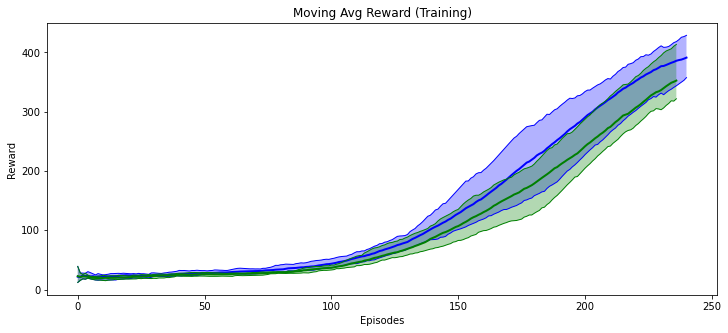

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(ddqn_max_train_reward, 'b', linewidth=1)
plt.plot(ddqn_min_train_reward, 'b', linewidth=1)
plt.plot(ddqn_mean_train_reward, 'b', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_train_reward, ddqn_max_train_reward, facecolor='b', alpha=0.3)

plt.plot(dueling_ddqn_max_train_reward, 'g', linewidth=1)
plt.plot(dueling_ddqn_min_train_reward, 'g', linewidth=1)
plt.plot(dueling_ddqn_mean_train_reward, 'g', linewidth=2)
plt.fill_between(dueling_ddqn_episodes, dueling_ddqn_min_train_reward, dueling_ddqn_max_train_reward, facecolor='g', alpha=0.3)

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

The training curves of dueling DDQN are narrower and end sooner than DDQN. This suggests that dueling DDQN isn’t only learning in fewer samples, but also learning more stable policies.

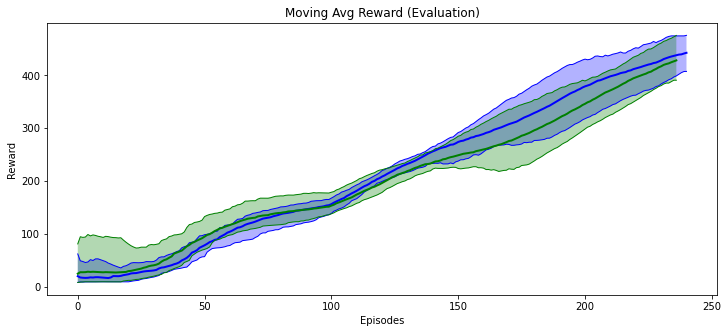

In [78]:
plt.figure(figsize=(12,5))

plt.plot(ddqn_max_eval_score, 'b', linewidth=1)
plt.plot(ddqn_min_eval_score, 'b', linewidth=1)
plt.plot(ddqn_mean_eval_score, 'b', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_eval_score, ddqn_max_eval_score, facecolor='b', alpha=0.3)

plt.plot(dueling_ddqn_max_eval_score, 'g', linewidth=1)
plt.plot(dueling_ddqn_min_eval_score, 'g', linewidth=1)
plt.plot(dueling_ddqn_mean_eval_score, 'g', linewidth=2)
plt.fill_between(dueling_ddqn_episodes, dueling_ddqn_min_eval_score, dueling_ddqn_max_eval_score, facecolor='g', alpha=0.3)

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

The evaluation plot shows the same pattern.

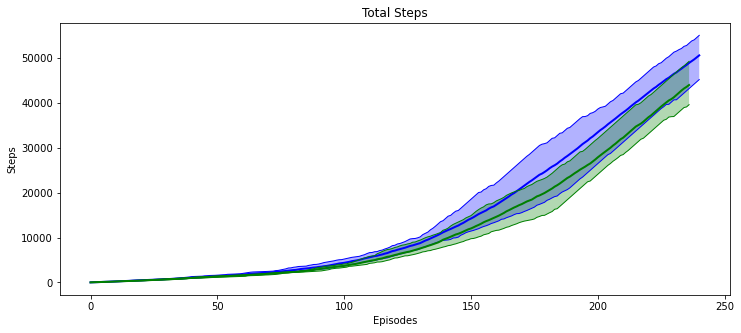

In [79]:
plt.figure(figsize=(12,5))

plt.plot(ddqn_max_steps, 'b', linewidth=1)
plt.plot(ddqn_min_steps, 'b', linewidth=1)
plt.plot(ddqn_mean_steps, 'b', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_steps, ddqn_max_steps, facecolor='b', alpha=0.3)

plt.plot(dueling_ddqn_max_steps, 'g', linewidth=1)
plt.plot(dueling_ddqn_min_steps, 'g', linewidth=1)
plt.plot(dueling_ddqn_mean_steps, 'g', linewidth=2)
plt.fill_between(dueling_ddqn_episodes, dueling_ddqn_min_steps, dueling_ddqn_max_steps, facecolor='g', alpha=0.3)

plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')
plt.show()

Dueling DDQN consumes less data and fewer steps.

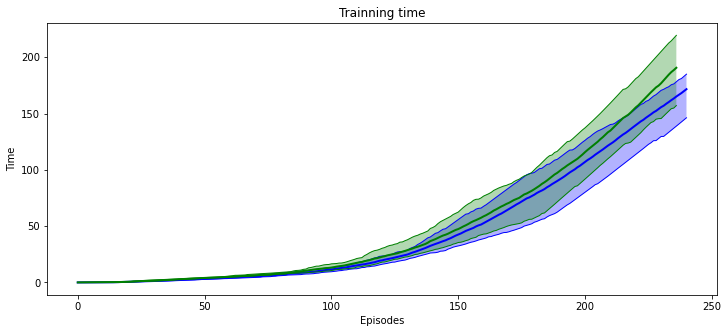

In [80]:
plt.figure(figsize=(12,5))

plt.plot(ddqn_max_time, 'b', linewidth=1)
plt.plot(ddqn_min_time, 'b', linewidth=1)
plt.plot(ddqn_mean_time, 'b', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_time, ddqn_max_time, facecolor='b', alpha=0.3)

plt.plot(dueling_ddqn_max_time, 'g', linewidth=1)
plt.plot(dueling_ddqn_min_time, 'g', linewidth=1)
plt.plot(dueling_ddqn_mean_time, 'g', linewidth=2)
plt.fill_between(dueling_ddqn_episodes, dueling_ddqn_min_time, dueling_ddqn_max_time, facecolor='g', alpha=0.3)

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')
plt.show()

But it takes longer to train. Maybe because we’re now updating the target network
every time step? Maybe the dueling network? Experiment and find out!

## Prioritizing the replay of experiences

At the moment, the agent samples experience tuples from the replay memory uniformly at random. Intuitively, this seems like an inferior way of replaying experiences. It doesn’t feel right that the agent spends time and compute power "learning" things that have nothing to offer to the current state of the agent. But, while this is evident, more difficult is determining a different sampling behaviour. We can think that since the agent has to get the highest cumulative discounted rewards possible, we can replay experiences with high reward only. However, this obvious approach didn’t work. The agent needs also other types of experiences! 

What we’re looking for is to learn from experiences with unexpected value, **surprising experiences**. The agent has a view of the world, he anticipates outcomes, and when the difference between expectation and reality is significant, we know he can learn something from that! In reinforcement learning, this **measure of surprise** is given by the TD error: it provides the difference between the agent’s current estimate and target value. The absolute difference between these values indicates how unexpected this experience is, and how much new information the agent receives, which makes it a good indicator for learning opportunity ([Tom Schaul et al. **Prioritized Experience Replay** ICLR 2016](https://arxiv.org/abs/1511.05952?context=cs)):

$\begin{align}
|\delta_i| = |r + \gamma Q\left(s', \underset{a'}{\arg \max}\text{ } Q\left(s',a';\theta_i,\alpha_i,\beta_i\right);\theta^-,\alpha^-,\beta^-\right)-Q\left(s,a;\theta_i,\alpha_i,\beta_i\right) |
\end{align}$

The TD error isn’t the perfect indicator, the best criterion for learning the most is inside the network and hidden behind parameter updates. But, it seems impractical to calculate gradients for all experiences in the replay buffer every time step. The good thing about the TD error is that the machinery to calculate it is in there already, and of course, the fact that the TD error is still a good signal for prioritizing the replay of experiences.

So, we can  insert experience into the replay memory as a tuple containing also to the TD error, so then we can pull out the top experiences from the buffer sorteding by this new value. However there two issues with this approach: first, we are calculating the TD errors twice (before inserting it into the memory, and then again when we train the network); second we’re ignoring the fact that TD errors change every time the network changes, because they’re calculated using the network. The solution can’t be updating all of the TD errors every time step, it’s simply not cost effective.

A workaround for both these problems is to update the TD errors only for experiences that are used to update the network (the replayed experiences) and insert new experiences with the highest magnitude TD error in the memory. However, other issues arise: a TD error of zero in the first update means that experience will likely never be replayed again, moreover when using function approximators, errors shrink slowly, and this means that updates concentrate heavily in a small subset of the replay memory.

For these reasons, we need a strategy for sampling experiences based on the TD errors, but **stochastically, not greedily**: in that way we can simultaneously ensure all experiences have a chance of being replayed, and that the probabilities of sampling experiences are monotonic in the absolute TD error.

First we calculate priorities for each sample in the buffer based on TD errors:

$\begin{align}
p_i = |\delta_i| + \epsilon
\end{align}$


we add a small constant, epsilon, to make sure zero TD error samples still have a chance of being replayed.

Then, we scale the priority by exponentiating it to a hyperparameter $\alpha$ that allows us to interpolate between uniform and prioritized sampling:

$\begin{align}
P(i)=\frac{p_i^\alpha}{\sum\limits_{k}{p_k^\alpha} } 
\end{align}$

When $\alpha$ is zero, all values become one, therefore, an equal priority; when $\alpha$ is one, all values stay the same as the absolute TD error; a value in between blends the two sampling strategies. The scaled priorities are converted to actual probabilities by dividing by the sum of the values. 

One issue with this approach is that it’s sensitive to outliers. That means experiences with much higher TD error than the rest (whether by fact or noise) are sampled more often than those with low magnitudes, which may be an undesired side effect.

A slightly different prioritization approach is to sample them using the rank of the samples when sorted by their absolute TD error. Rank here means the position of the sample when sorted in descending order by the absolute TD error—nothing else:

$\begin{align}
p_i = \frac{1}{\text{rank}(i)}
\end{align}$

And again, for calculating priorities, we proceed by scaling the priorities with alpha, the same as with the proportional strategy. And then, we calculate actual probabilities from these priorities, also, as before, normalizing the values so that the sum is one.

Another problem is that the prioritization introduces a form of sampling bias toward high-priority samples (more chances to be selected). With prioritization we are not uniformly sampling from the replay memory and we start over-sampling those with high priority.  

Since the samples will be biased toward important experiences, we must compensate for this bias during training by downweighting the experiences according to their importance, or else the model will just overfit the important experiences. To be clear, **we want important experiences to be
sampled more often, but this also means we must give them a lower weight during training**. The way to mitigate this bias is to use a technique called **weighted importance sampling**: it consists of scaling the TD errors by weights calculated with the probabilities of each sample. We can calculate the importance-sampling weights by multiplying each probability by the number of samples in the replay buffer ($N$):

$\begin{align}
w_i = \left(\frac{1}{N} \frac{1}{P_i}\right)^\beta
\end{align}$

we add the $\beta$ hyperparameter that allows us to tune the degree of the corrections. When beta is zero, there’s no correction; when beta is one, there’s a full correction of the bias. Training is highly unstable at the beginning, so the importance sampling corrections matter more near the end of training. Thus, $\beta$ starts small (values of 0.4 to 0.6 are commonly used) and anneals towards one.

Additionally, we want to normalize the weights by their max so that the max weight becomes one, and all other weights scale down the TD errors. This way, we keep TD errors from growing too much and keep training stable:

$\begin{align}
w_i = \frac{w_i}{max_j(w_j)} 
\end{align}$

These importance-sampling weights are used in the loss function. Instead of using the TD
errors straight in the gradient updates, we multiply them by the importance-sampling weights: 

$\begin{align}
\nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim P(D)} \left[ w \left( r + \gamma Q\left(s',\underset{a'}{\arg \max} Q\left(s',a';\theta_i\right);\theta^-\right) - Q\left(s,a;\theta_i\right)\right) \nabla_{\theta_i} Q\left(s,a;\theta_i\right) \right]
\end{align}$

Notice how we’re using the normalized importance-sampling weights to modify the magnitude of the TD error, and that we changed the "U" for a "P", because we’re doing a prioritized sampling, and not uniformly at random.

We can implement the prioritized replay memory in Python:

In [92]:
class PrioritizedReplayMemory():
    def __init__(self, max_samples=10000, batch_size=64, 
                 alpha=0.6, beta0=0.1, beta_rate=0.99992):
        self.max_samples = max_samples
        self.memory = np.empty(shape=(self.max_samples, 2), dtype=np.ndarray)
        self.batch_size = batch_size
        self.n_entries = 0
        self.next_index = 0
        self.td_error_index = 0
        self.sample_index = 1
        self.alpha = alpha 
        self.beta = beta0
        self.beta0 = beta0
        self.beta_rate = beta_rate

    def store(self, sample):
        
        # calculate the priority for the sample
        priority = 1.0
        if self.n_entries > 0:
            priority = self.memory[:self.n_entries, self.td_error_index].max()
            
        # insert the sample and its priority into the memory
        self.memory[self.next_index, self.td_error_index] = priority
        self.memory[self.next_index, self.sample_index] = np.array(sample, dtype=object)
        
        # increase the variable that indicates the number of experiences in the buffer
        self.n_entries = min(self.n_entries + 1, self.max_samples)
        
        # calculare index at which the next experience will be inserted
        # this variable loops back around from max_samples to 0 and goes back up
        self.next_index += 1
        self.next_index = self.next_index % self.max_samples
    
    def update(self, idxs, td_errors):
        # takes the array of experiences ids, and new TD error values
        # insert the absolute TD errors into the right place.
        self.memory[idxs, self.td_error_index] = np.abs(td_errors)

    def _update_beta(self):
        self.beta = min(1.0, self.beta * self.beta_rate**-1)
        return self.beta

    def sample(self, batch_size=None):
        
        # Calculate the batch_size
        batch_size = self.batch_size if batch_size == None else batch_size
        
        #anneal beta
        self._update_beta()
        
        # remove zeroed rows from entries
        entries = self.memory[:self.n_entries]
        
        # calculate priorities: the absolute TD error plus a small constant 
        # to avoid zero priorities
        priorities = entries[:, self.td_error_index] + 1e-6
        
        # go from priorities to probabilities
        scaled_priorities = priorities**self.alpha        
        probs = np.array(scaled_priorities/np.sum(scaled_priorities), dtype=np.float64)
        
        # calculate the importance-sampling weights using the probabilities
        weights = (self.n_entries * probs)**-self.beta
        normalized_weights = weights/weights.max()
        
        # sample experiences in the memory using the probabilities
        idxs = np.random.choice(self.n_entries, batch_size, replace=False, p=probs)
        samples = np.array([entries[idx] for idx in idxs])
        
        # stack the samples by ids, weights, and experience tuples, and return them.
        samples_stacks = [np.vstack(batch_type) for batch_type in np.vstack(samples[:, self.sample_index]).T]
        idxs_stack = np.vstack(idxs)
        weights_stack = np.vstack(normalized_weights[idxs])
        
        return idxs_stack, weights_stack, samples_stacks

    def __len__(self):
        return self.n_entries
    
    def __repr__(self):
        return str(self.memory[:self.n_entries])
    
    def __str__(self):
        return str(self.memory[:self.n_entries])

Again, we can improve all value-based deep reinforcement learning methods usgin the improved  replay mempry. Most of the thing are still as before (network architecture, tartget, loss function, optimizer, exploration strategy, polyak avereging), however this time we use weighted important sampling to adjust the TD errors (which changes the loss function) and a prioritized replay buffer with proportional prioritization:

In [93]:
class PER_Dueling_DDQN():
    def __init__(self, env, replay_memory, online_model, target_model, 
                 optimizer, max_gradient_norm, train_strategy, eval_strategy,
                 seed, gamma, n_warmup_batches, update_target_every_steps, tau):
        torch.manual_seed(seed); 
        np.random.seed(seed); 
        random.seed(seed)
        env.seed(seed)
        
        self.env = env
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.seed = seed
        self.gamma = gamma
        self.max_gradient_norm = max_gradient_norm
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

    def optimize_model(self, experiences):
        idxs, weights, (states, actions, rewards, next_states, is_terminals) = experiences
        weights = torch.from_numpy(weights).float().to('cpu')
        batch_size = len(is_terminals)
        
        argmax_a_q_sp = self.online_model(next_states).max(1)[1]
        q_sp = self.target_model(next_states).detach()
        max_a_q_sp = q_sp[np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = (weights * td_error).pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        value_loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), self.max_gradient_norm)
        self.optimizer.step()

        priorities = np.abs(td_error.detach().cpu().numpy())
        self.replay_memory.update(idxs, priorities)

    def interaction_step(self, state):
        action = self.train_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = self.env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_memory.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        result = np.empty((max_episodes, 4))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = self.env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state)
                
                min_samples = self.replay_memory.batch_size * self.n_warmup_batches
                if len(self.replay_memory) > min_samples:
                    experiences = self.replay_memory.sample()
                    idxs, weights, samples = experiences
                    experiences = self.online_model.load(samples)
                    experiences = (idxs, weights) + (experiences,)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()

                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate()

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            total_elapsed = time.time() - training_start
            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            debug_message = 'episode {:04}, steps {:06}, '
            debug_message += 'avg score {:05.1f}\u00B1{:05.1f}, '
            debug_message = debug_message.format(episode-1, total_step, mean_100_train_reward, std_100_train_reward)
            print(debug_message, end='\r', flush=True)
                   
            if reached_debug_time or training_is_over:
                print(debug_message, flush=True)
                last_debug_time = time.time()
            
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes')
                if reached_max_episodes: print(u'--> reached_max_episodes')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward')
                break
                
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
        return result, final_eval_score, final_eval_std, training_time
    
    def evaluate(self, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = self.env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.eval_strategy.select_action(self.online_model, s)
                s, r, d, _ = self.env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

## PER vs Dueling DDQN

The prioritized replay buffer uses fewer samples than any of the previous methods. And as you can see it in the graphs below, it even makes things look more stable. 

In [94]:
per_ddqn_results = []
best_per_ddqn_agent, best_per_ddqn_eval_score = None, float('-inf')

gamma = 1.00
max_minutes = 30
max_episodes = 10000
goal_mean_100_reward = 475
tau = 0.1
max_gradient_norm = float('inf')

target_update_steps = 1
n_warmup_batches = 5

nS, nA = env.observation_space.shape[0], env.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')
    
    online_model = FCDuelingQ(nS, nA, hidden_dims=(512,128))
    target_model = FCDuelingQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(online_model.parameters(), lr=0.0005)
    replay_memory = ReplayMemory(max_size=50000, batch_size=64)
    
    replay_memory = PrioritizedReplayMemory(max_samples=20000, batch_size=64,
                                            alpha=0.6, beta0=0.1, beta_rate=0.99995)
    
    train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
    eval_strategy = GreedyStrategy()
            
    agent = PER_Dueling_DDQN(env, replay_memory, online_model, target_model, optimizer,
                             max_gradient_norm, train_strategy, eval_strategy, 
                             seed, gamma, n_warmup_batches, target_update_steps, tau)
    result, score, score_std, training_time = agent.train(max_minutes, max_episodes, goal_mean_100_reward)

    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'
          .format(score, score_std, training_time))
    
    per_ddqn_results.append(result)
    if score > best_per_ddqn_eval_score:
        best_per_ddqn_eval_score = score
        best_per_ddqn_agent = agent
        
per_ddqn_results = np.array(per_ddqn_results)

Training started...
episode 0000, steps 000016, avg score 016.0±000.0, 
episode 0153, steps 010276, avg score 090.8±079.5, 
episode 0181, steps 017858, avg score 155.2±108.4, 
episode 0211, steps 024999, avg score 209.9±096.6, 
episode 0228, steps 031817, avg score 258.8±116.1, 
episode 0242, steps 037998, avg score 300.7±123.6, 
episode 0254, steps 043872, avg score 331.0±130.9, 
episode 0268, steps 049835, avg score 353.9±137.2, 
episode 0281, steps 055831, avg score 379.7±139.5, 
episode 0293, steps 061739, avg score 415.6±123.3, 
episode 0300, steps 064652, avg score 428.2±118.6, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 500.00±0.00 in 576.08s training time

Training started...
episode 0000, steps 000034, avg score 034.0±000.0, 
episode 0134, steps 008161, avg score 072.7±067.3, 
episode 0162, steps 013686, avg score 118.1±091.2, 
episode 0186, steps 018909, avg score 159.7±092.1, 
episode 0208, steps 023774, avg score 192.1±092.3, 
episode 0223, st

In [87]:
per_ddqn_max_steps, per_ddqn_max_train_reward, per_ddqn_max_eval_score, per_ddqn_max_time = np.max(per_ddqn_results, axis=0).T
per_ddqn_min_steps, per_ddqn_min_train_reward, per_ddqn_min_eval_score, per_ddqn_min_time = np.min(per_ddqn_results, axis=0).T
per_ddqn_mean_steps, per_ddqn_mean_train_reward, per_ddqn_mean_eval_score, per_ddqn_mean_time = np.mean(per_ddqn_results, axis=0).T
per_ddqn_episodes = np.arange(len(per_ddqn_mean_steps))

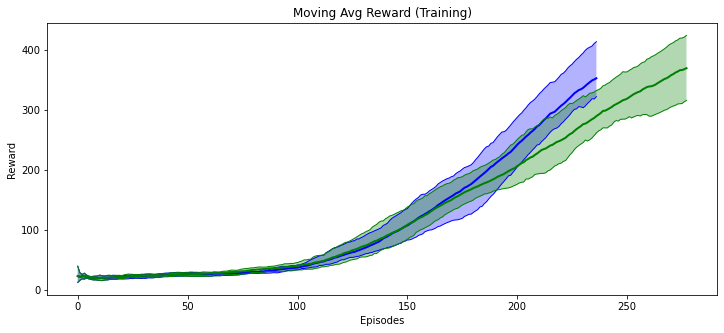

In [88]:
plt.figure(figsize=(12,5))

plt.plot(dueling_ddqn_max_train_reward, 'b', linewidth=1)
plt.plot(dueling_ddqn_min_train_reward, 'b', linewidth=1)
plt.plot(dueling_ddqn_mean_train_reward, 'b', linewidth=2)
plt.fill_between(dueling_ddqn_episodes, dueling_ddqn_min_train_reward, dueling_ddqn_max_train_reward, facecolor='b', alpha=0.3)

plt.plot(per_ddqn_max_train_reward, 'g', linewidth=1)
plt.plot(per_ddqn_min_train_reward, 'g', linewidth=1)
plt.plot(per_ddqn_mean_train_reward, 'g', linewidth=2)
plt.fill_between(per_ddqn_episodes, per_ddqn_min_train_reward, per_ddqn_max_train_reward, facecolor='g', alpha=0.3)

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

PER uses data much more efficiently, and as you can see, it passes the environment in fewer episodes.

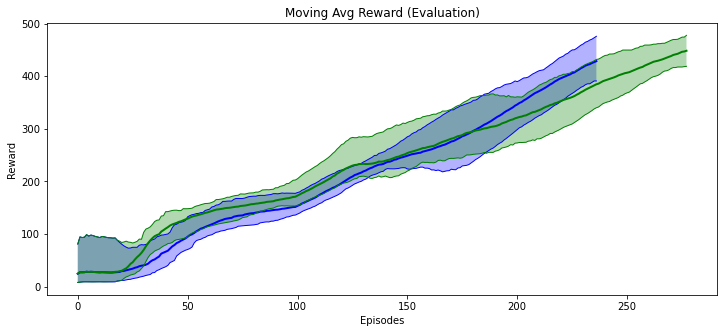

In [89]:
plt.figure(figsize=(12,5))

plt.plot(dueling_ddqn_max_eval_score, 'b', linewidth=1)
plt.plot(dueling_ddqn_min_eval_score, 'b', linewidth=1)
plt.plot(dueling_ddqn_mean_eval_score, 'b', linewidth=2)
plt.fill_between(dueling_ddqn_episodes, dueling_ddqn_min_eval_score, dueling_ddqn_max_eval_score, facecolor='b', alpha=0.3)

plt.plot(per_ddqn_max_eval_score, 'g', linewidth=1)
plt.plot(per_ddqn_min_eval_score, 'g', linewidth=1)
plt.plot(per_ddqn_mean_eval_score, 'g', linewidth=2)
plt.fill_between(per_ddqn_episodes, per_ddqn_min_eval_score, per_ddqn_max_eval_score, facecolor='g', alpha=0.3)

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

Nothing really different in the evaluation plot in terms of sample complexity, but you can also see a bit more stability than previous methods.

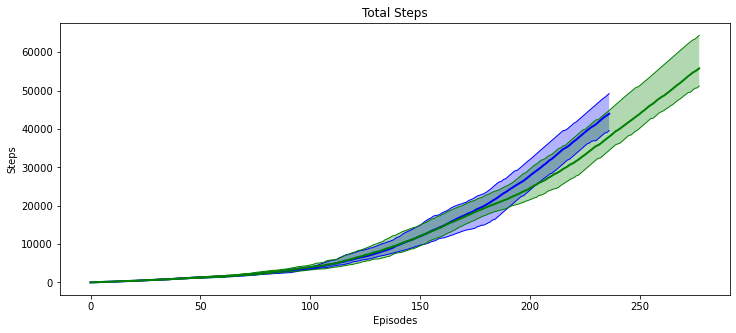

In [90]:
plt.figure(figsize=(12,5))

plt.plot(dueling_ddqn_max_steps, 'b', linewidth=1)
plt.plot(dueling_ddqn_min_steps, 'b', linewidth=1)
plt.plot(dueling_ddqn_mean_steps, 'b', linewidth=2)
plt.fill_between(dueling_ddqn_episodes, dueling_ddqn_min_steps, dueling_ddqn_max_steps, facecolor='b', alpha=0.3)

plt.plot(per_ddqn_max_steps, 'g', linewidth=1)
plt.plot(per_ddqn_min_steps, 'g', linewidth=1)
plt.plot(per_ddqn_mean_steps, 'g', linewidth=2)
plt.fill_between(per_ddqn_episodes, per_ddqn_min_steps, per_ddqn_max_steps, facecolor='g', alpha=0.3)

plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')
plt.show()

The real indication of sample complexity is the number of steps, not episodes, because episodes contain a variable number of steps in this environment. However, the pattern is the same. PER is more sample efficient than all previous methods.

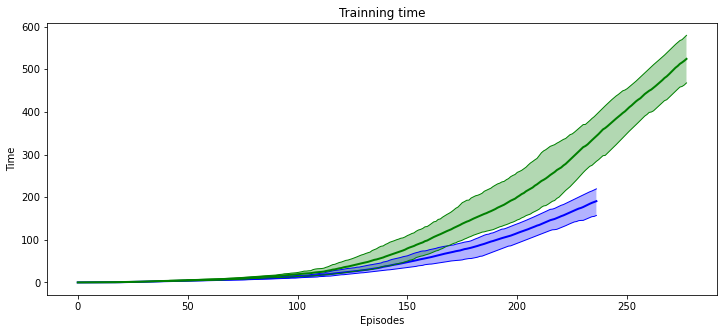

In [91]:
plt.figure(figsize=(12,5))

plt.plot(dueling_ddqn_max_time, 'b', linewidth=1)
plt.plot(dueling_ddqn_min_time, 'b', linewidth=1)
plt.plot(dueling_ddqn_mean_time, 'b', linewidth=2)
plt.fill_between(dueling_ddqn_episodes, dueling_ddqn_min_time, dueling_ddqn_max_time, facecolor='b', alpha=0.3)

plt.plot(per_ddqn_max_time, 'g', linewidth=1)
plt.plot(per_ddqn_min_time, 'g', linewidth=1)
plt.plot(per_ddqn_mean_time, 'g', linewidth=2)
plt.fill_between(per_ddqn_episodes, per_ddqn_min_time, per_ddqn_max_time, facecolor='g', alpha=0.3)

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')
plt.show()

But look at this! PER is much slower than dueling DDQN. But know that this is an implementation-specific
issue. If you get a highquality implementation of PER, this shouldn’t happen.

## Challenges

Value-based methods are **sensitive to hyperparameters**. Try it for yourself: change any hyperparameter. You can find more values that don’t work than values that do.

Second, value-based methods assume they interact with a Markovian environment, that the states contain all information required by the agent. This assumption dissipates as we move away from bootstrapping and value-based methods in general. 

Last, the combination of bootstrapping, off-policy learning, and function approximators are known conjointly as **the deadly triad**: it is known to produce divergence, researchers still don’t know exactly how to prevent it. 

The fundamental takeaway is to know that value-based deep reinforcement learning methods are well known to diverge, and that’s their weakness. How to fix it is still a research question, but sound practical advice is to use target networks, replay buffers, double learning, sufficiently small learning rates (but not too small), and maybe a little bit of patience.